# Flight Departure Delays from the New York City Metro Area
#### Predicting Departure Delays during the summer travel months from La Guardia, John F. Kenney, and Newark International Airports

#### Data: Flight data from June - August 2019 from La Guardia, John F. Kennedy, and Newark International Airports

#### Flight delay: The Federal Aviation Administration (FAA) considers a flight to be delayed when it is 15 minutes later than its scheduled time. 

Different Types of Delays:
- Air Carrier: The cause of the cancellation or delay was due to circumstances within the airline's control (e.g. maintenance or crew problems, aircraft cleaning, baggage loading, fueling, etc.).
- Extreme Weather: Significant meteorological conditions (actual or forecasted) that, in the judgment of the carrier, delays or prevents the operation of a flight such as tornado, blizzard or hurricane.
- National Aviation System (NAS): Delays and cancellations attributable to the national aviation system that refer to a broad set of conditions, such as non-extreme weather conditions, airport operations, heavy traffic volume, and air traffic control.
- Late-arriving aircraft: A previous flight with same aircraft arrived late, causing the present flight to depart late.
- Security: Delays or cancellations caused by evacuation of a terminal or concourse, re-boarding of aircraft because of security breach, inoperative screening equipment and/or long lines in excess of 29 minutes at screening areas.

Sources:
- https://www.bts.gov/topics/airlines-and-airports/understanding-reporting-causes-flight-delays-and-cancellations
- https://en.wikipedia.org/wiki/Flight_cancellation_and_delay
- 2018 Flights (https://www.kaggle.com/yuanyuwendymu/airline-delay-and-cancellation-data-2009-2018/notebooks)
- 2015 Flights (https://www.kaggle.com/usdot/flight-delays/notebooks)
- Flights: https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time
- Medium: https://medium.com/@hwangxtine/predicting-flight-delays-8a64db464ff5

In [1]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../helper_functions')

import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from collections import Counter

from ipywidgets import interactive, FloatSlider
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from mlxtend.plotting import plot_decision_regions
import psycopg2 as pg

from sklearn import metrics, linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn.metrics import mean_squared_error, confusion_matrix, plot_confusion_matrix, classification_report, precision_recall_curve, fbeta_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from visualize import plot_boundaries
from xgboost import XGBClassifier, XGBRegressor
import xgboost


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

# from visualize import generate_moons_df, preprocess, plot_boundaries

from infer_sql_schema import sql_schema, print_all_schema

from yellowbrick.model_selection import FeatureImportances

## 1.0 Data Collection and Clean-Up

Using the Bureau of Transportation (BTS) as the primary data source, all flight information was collected from here. Specific data collected were Origin, Destination, Carrier, Departure Time, Departure Delay, Arrival Time, Arrival Delay, Distance from airports, Time of Flight, and among others to ensure a holistic approach to the data analysis.

The separate datasets collected below were concatenated and then filtered by only La Guardia (LGA), John F. Kennedy (JFK), and Newark (EWR) International Airports.

Then a DELAY column was created for the purposes of a binary classification. If the departure delay was greater than 15 minutes then it would be considered delayed based on FAA guidelines, otherwise, on-time.

In [2]:
df_june_2019 = pd.read_csv('./../../Data/flights/june2019.csv')
df_july_2019 = pd.read_csv('./../../Data/flights/july2019.csv')
df_aug_2019 = pd.read_csv('./../../Data/flights/aug2019.csv')

In [3]:
df_sum_2019 = pd.concat([df_june_2019,df_july_2019,df_aug_2019])

In [4]:
mask_NjNy = (df_sum_2019['ORIGIN'] == 'JFK') | (df_sum_2019['ORIGIN'] == 'LGA') | (df_sum_2019['ORIGIN'] == 'EWR')
df_sum_NjNy_2019 = df_sum_2019[mask_NjNy]

In [5]:
df_sum_NjNy_2019 = df_sum_NjNy_2019.iloc[:,:-1]

In [6]:
#Binary classificaton
df_sum_NjNy_2019['DELAY'] = ['DELAY' if x >= 15 else 'ONTIME' for x in df_sum_NjNy_2019['DEP_DELAY']]

In [7]:
df_sum_NjNy_2019.to_csv(r'/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/sum_NjNy_2019.csv', index=False, header=True)

In [8]:
df_sum_NjNy_2019 = pd.read_csv('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/sum_NjNy_2019.csv')

Loading into SQL Database then retrieving for further analysis.

In [12]:
sql_schema('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/sum_NjNy_2019.csv','flights_june_2019')

CREATE TABLE sum_NjNy_2019 (
    DAY_OF_WEEK            numeric,
    FL_DATE                varchar,
    OP_CARRIER             varchar,
    OP_CARRIER_FL_NUM      numeric,
    ORIGIN                 varchar,
    ORIGIN_CITY_NAME       varchar,
    DEST                   varchar,
    DEST_CITY_NAME         varchar,
    CRS_DEP_TIME           numeric,
    DEP_TIME               numeric,
    DEP_DELAY              numeric,
    CRS_ARR_TIME           numeric,
    ARR_TIME               numeric,
    ARR_DELAY              numeric,
    CRS_ELAPSED_TIME       numeric,
    ACTUAL_ELAPSED_TIME    numeric,
    AIR_TIME               numeric,
    DISTANCE               numeric,
    CARRIER_DELAY          numeric,
    WEATHER_DELAY          numeric,
    NAS_DELAY              numeric,
    SECURITY_DELAY         numeric,
    LATE_AIRCRAFT_DELAY    numeric,
    DELAY                  varchar);

COPY sum_NjNy_2019
FROM '/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/sum_NjNy_2

In [15]:
connection_args = {
    'host': 'localhost', 
    'dbname': 'ridwan',    
    'port': 5432          
}

connection = pg.connect(**connection_args)
query = "SELECT * FROM sum_NjNy_2019;"

df_sum_NjNy_2019 = pd.read_sql(query, connection)

## 2.0 Feature Selection

The initial features were day of the week, carrier, origin, destination, departure time, and distance. I wanted to supply the model with only information it would know before someone boarded plane. So things such as arrival time and elapsed air time were removed because these would be unknowns before boarding a plane.

The set was broken into a X-set (features) and y-set (target). They were both pickled for ease of retrieval later. 

In [9]:
#Dropping delay columns; save for later potentially
df_sum_NjNy_2019_delay_dropped = df_sum_NjNy_2019.drop(df_sum_NjNy_2019.loc[:,'CARRIER_DELAY':'LATE_AIRCRAFT_DELAY'].columns, axis=1)
df_sum_NjNy_2019_delay_dropped = df_sum_NjNy_2019_delay_dropped.dropna()

# Changing Airline string names to numerical 
# Didn't use
# df_sum_NjNy_2019_delay_dropped['OP_CARRIER'] = df_sum_NjNy_2019_delay_dropped['OP_CARRIER'].replace({'B6':1, 'UA':2, 'AS':3, 'YV':4, 'EV':5, 'OO':6, 'AA':7, 'MQ':8, '9E':9, 'G4':10, 'F9':11, 'YX':12, 'NK':13, 'OH':14, 'HA':15, 'WN':16, 'DL':17})

# Changing Origin string names to numerical 
# Didn't use
# df_sum_NjNy_2019_delay_dropped['ORIGIN'] = df_sum_NjNy_2019_delay_dropped['ORIGIN'].replace({'JFK':1, 'LGA' : 2, 'EWR' : 3})

# Changing Destination string names to numerical 
# Didn't use
# df_sum_NjNy_2019_delay_dropped['DEST'] = df_sum_NjNy_2019_delay_dropped['DEST'].replace({'LAX':1, 'DEN':2, 'SLC':3, 'SMF':4, 'DFW':5, 'AUS':6, 'MIA':7, 'MSY':8, 'CHS':9, 'BOS':10, 'MCO':11, 'RSW':12, 'RDU':13, 'SFO':14, 'ORD':15, 'LAS':16, 'IAH':17, 'MCI':18, 'TPA':19, 'SNA':20, 'ATL':21, 'PBI':22, 'SAN':23, 'FLL':24, 'MYR':25, 'PDX':26, 'SJU':27, 'STT':28, 'BNA':29, 'CLE':30, 'BQN':31, 'SRQ':32, 'IAD':33, 'PHX':34, 'HNL':35,'SAT':36, 'SJC':37, 'PVD':38, 'SAV':39, 'GSO':40, 'CLT':41, 'CMH':42, 'CVG':43, 'RIC':44,'IND':45, 'ORF':46, 'DTW':47, 'ROC':48, 'CHA':49, 'PWM':50, 'BTV':51, 'ABQ':52, 'BUF':53, 'SYR':54, 'LGB':55, 'ONT':56, 'BUR':57, 'HOU':58, 'DCA':59, 'ILM':60, 'TYS':61, 'PHL':62,  'PIT':63, 'DAY':64, 'BWI':65, 'CHO':66, 'MSP':67, 'GSP':68, 'OMA':69, 'MKE':70, 'AVL':71, 'BHM':72, 'SDF':73, 'STL':74, 'EYW':75, 'MSN':76, 'JAX':77, 'GRR':78, 'MEM':79, 'BGR':80, 'MDW':81, 'DAL':82, 'ROA':83, 'CAK':84, 'DSM':85, 'LEX':86, 'ORH':87, 'PSE':88, 'ACK':89,'OKC':90, 'HHH':91, 'CAE':92, 'DAB':93, 'VPS':94, 'RNO':95, 'OAK':96, 'MVY':97, 'XNA':98, 'MHT':99, 'TVC':100, 'BZN':101, 'PNS':102, 'JAC':103, 'HYA':104, 'ANC':105, 'RAP':106, 'SBN':107, 'SEA':108})

# df_sum_NjNy_2019_delay_dropped['DAY_OF_WEEK'] = df_sum_NjNy_2019_delay_dropped['DAY_OF_WEEK'].replace({1: 'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'})

# df_sum_NjNy_2019_delay_dropped['OP_CARRIER'] = df_sum_NjNy_2019_delay_dropped['OP_CARRIER'].replace({'B6':'Jetblue', 'UA':'United', 'AS':'Alaska', 'YV':'Mesa', 'EV':'AtlanticSouthest', 'OO':'Skywest', 'AA':'AmericanAirlines', 'MQ':'AmericanEagle', '9E':'Endeavor', 'G4':'Allegiant', 'F9':'Frontier', 'YX':'Republic', 'NK':'Spirit', 'OH':'PSA', 'HA':'Hawaiian', 'WN':'Southwest', 'DL':'Delta'})

#Convert actual time from float to time
# df_sum_NjNy_2019_delay_dropped['CRS_DEP_TIME'] = pd.to_datetime(df_sum_NjNy_2019_delay_dropped['CRS_DEP_TIME'], format='%H%M%S').dt.time

#ACTUAL_ELAPSED_TIME drops KNN score significantly
X = df_sum_NjNy_2019_delay_dropped.drop(['DELAY','ORIGIN_CITY_NAME','DEST_CITY_NAME','DEP_DELAY','ARR_DELAY','OP_CARRIER_FL_NUM','FL_DATE','ARR_TIME','CRS_ARR_TIME','CRS_DEP_TIME','CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME'], axis=1)

y = df_sum_NjNy_2019_delay_dropped['DELAY']

In [10]:
X.to_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_X.pickle')
y.to_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_y.pickle')

In [11]:
X = pd.read_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_X.pickle')
y = pd.read_pickle('/Users/ridwan/Documents/DataScience/Metis/Metis_Projects/Data/flights/df_y.pickle')

In [12]:
X

,DAY_OF_WEEK,OP_CARRIER,ORIGIN,DEST,DEP_TIME,DISTANCE
0,1,AS,JFK,SEA,652.0,2422.0
1,1,AS,EWR,SEA,1708.0,2402.0
2,1,AS,EWR,SEA,558.0,2402.0
3,1,AS,EWR,PDX,1540.0,2434.0
4,1,AS,JFK,LAX,1256.0,2475.0
...,...,...,...,...,...,...
111943,7,AS,EWR,SEA,853.0,2402.0
111944,7,AS,JFK,LAX,1136.0,2475.0
111945,7,AS,JFK,SEA,1850.0,2422.0
111946,7,AS,JFK,LAX,728.0,2475.0


## 3.0 Train/Test Split

Train, test, split were applied to begin classification with the different models. K-Nearest Neighbor, Logistic Regression, Decision Tree, Random Forest, Gradient Boost, and Gaussian. 

Process: 

1. Split the dataset into three pieces: a **training set**, **validation set**, and **test/hold-out set**
2. Train the model on the **training set**.
3. Test the model on the **validation set**, and evaluate how well it did.
4. Locate the best model using cross-validation on the remaining data, and test it **using the test/hold-out set**
5. More reliable estimate of out-of-sample performance since hold-out set is **truly out-of-sample**

For KNN and Logistic Regression the features would need to be scaled.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#hold out 20% of the data for final testing
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state = 42)

In [99]:
#when using scaled solution, takes a long time 
scaler = StandardScaler()
scaler.fit(X_train)
X_train_preprocessed = scaler.transform(X_train)
X_val_preprocessed = scaler.transform(X_val)
X_test_preprocessed = scaler.transform(X_test)

### 3.1 OneHotEncoder 
Used to change all feature variables to numerical values

In [14]:
#specify categorical features
categoricals = ['OP_CARRIER', 'ORIGIN', 'DEST']

#continuous features
continuous = ['DAY_OF_WEEK','DEP_TIME','DISTANCE']

#replacement for dummy variables?
ohe = OneHotEncoder(sparse=False)

cat_matrix_X = ohe.fit_transform(X.loc[:, categoricals])

X_ohe = pd.DataFrame(cat_matrix_X,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X.index) #keep the same index values

#combine continuous and categorical data

X_preprocessed = pd.concat([X.loc[:, continuous], X_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_preprocessed = ss.fit_transform(X_preprocessed)

In [15]:
cat_matrix_train = ohe.fit_transform(X_train.loc[:, categoricals])

X_train_ohe = pd.DataFrame(cat_matrix_train,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_train.index) #keep the same index values

#combine continuous and categorical data

X_train_preprocessed = pd.concat([X_train.loc[:, continuous], X_train_ohe], axis=1)

#Scale data
ss = StandardScaler()
X_train_preprocessed = ss.fit_transform(X_train_preprocessed)

In [16]:
#transform validation set
cat_matrix_val = ohe.transform(X_val.loc[:, categoricals]) #remember to only transform on the test set!

X_val_ohe = pd.DataFrame(cat_matrix_val,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_val.index) #keep the same index values

X_val_preprocessed = pd.concat([X_val.loc[:, continuous], X_val_ohe], axis=1)
X_val_preprocessed = ss.transform(X_val_preprocessed)

In [17]:
#transform validation set
cat_matrix_test = ohe.transform(X_test.loc[:, categoricals]) #remember to only transform on the test set!

X_test_ohe = pd.DataFrame(cat_matrix_test,
                           columns=ohe.get_feature_names(categoricals), #create meaningful column names
                           index=X_test.index) #keep the same index values

X_test_preprocessed = pd.concat([X_test.loc[:, continuous], X_test_ohe], axis=1)
X_test_preprocessed = ss.transform(X_test_preprocessed)

## 4.0 Class Imbalance and Balancing Data

Now that all the data is cleaned. The class imabalance between Delays and On-Time departures were compared. We do not want the model to train on only one of the classes as that would lead to inaccurate scores.

In [18]:
target_count = y.value_counts()

In [19]:
# print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print(f'Percentage of Majority Class: {round(target_count[0] / sum(target_count), 4)*100}')

Class 0: 77806
Class 1: 29127
Proportion: 2.67 : 1
Percentage of Majority Class: 72.76


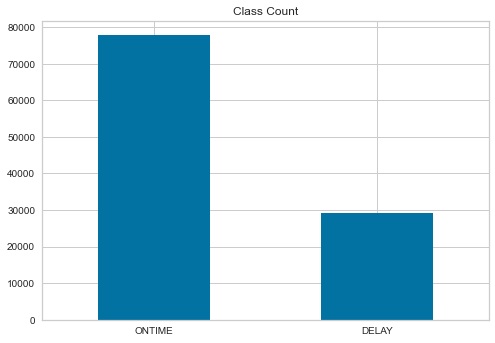

In [20]:
target_count.plot(kind='bar', title='Class Count', rot=0);

In [21]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

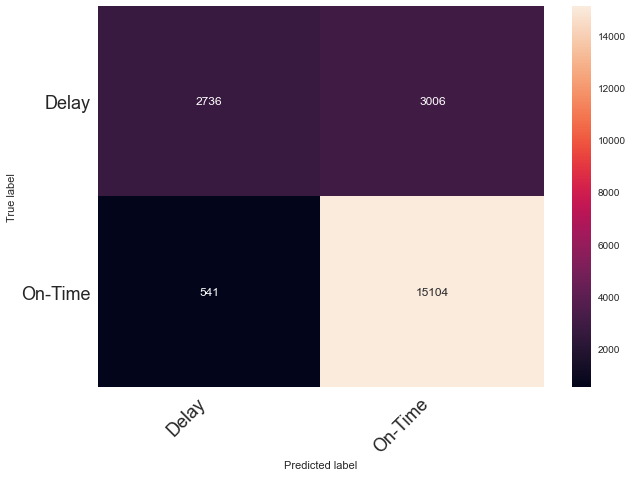

In [22]:
# We'll go straight to a robust classifier to show even they are prone to the metric trap
clf = XGBClassifier().fit(X_train_preprocessed, y_train)
y_pred = clf.predict(X_val_preprocessed)
conf_mat = confusion_matrix(y_true=y_val, y_pred=y_pred)
cm = print_confusion_matrix(conf_mat, ['Delay', 'On-Time'])

The above graph is evidence that most of the class count leans towards On-Time departures which in this case would skew the model.

### 4.1 Balancing the Data
We will try RandomOverSampler, SMOTE, ADASYN, and RandomUnderSampler to see which technique will give us the most balanced predicted values. If our data leans too far to Delayed or On-Time classifications it will skew the model. 

RandomOverSampler: Over-samples minority class, in this case DELAYS, by picking samples at random with replacement.

SMOTE: Synthesises new minority instances between existing (real) minority instances.

ADASYN (Adaptive Synthetic Oversampling): Instead of generating synthetic observations between any minority points, it puts more emphasis on the regions where the class imbalance is greatest. In other words, in the regions where the classifier is most likely to predict the majority class.

RandomUnderSampling: Under-samples the majority class, in this case On-Time, by randomly picking samples with or without replacement.

In [30]:
ros = RandomOverSampler(random_state=42)
X_ROS_train, y_ROS_train = ros.fit_sample(X_train_preprocessed,y_train)
X_ROS_val, y_ROS_val = ros.fit_sample(X_val_preprocessed,y_val)
print("Random OverSampling Train: ",Counter(y_ROS_train))
print("Random OverSampling Val: ",Counter(y_ROS_val))

smote = SMOTE(random_state=42)
X_SMOTE_train, y_SMOTE_train = smote.fit_sample(X_train_preprocessed,y_train)
X_SMOTE_val, y_SMOTE_val = smote.fit_sample(X_val_preprocessed,y_val)
print("\nSMOTE Train: ", Counter(y_SMOTE_train))
print("SMOTE Val: ", Counter(y_SMOTE_val))

adasyn = ADASYN(random_state = 42)
X_ADASYN_train, y_ADASYN_train = adasyn.fit_sample(X_train_preprocessed,y_train)
X_ADASYN_val, y_ADASYN_val = adasyn.fit_sample(X_val_preprocessed,y_val)
print("\nADASYN Train: ",Counter(y_ADASYN_train))
print("ADASYN Val: ",Counter(y_ADASYN_val))

rus = RandomUnderSampler(random_state=42)
X_RUS_train, y_RUS_train = rus.fit_sample(X_train_preprocessed,y_train)
X_RUS_val, y_RUS_val = rus.fit_sample(X_val_preprocessed,y_val)
print("\nRandom UnderSampling Train: ",Counter(y_RUS_train))
print("Random UnderSampling Val: ",Counter(y_RUS_val))

Random OverSampling Train:  Counter({'ONTIME': 46603, 'DELAY': 46603})
Random OverSampling Val:  Counter({'DELAY': 15645, 'ONTIME': 15645})

SMOTE Train:  Counter({'ONTIME': 46603, 'DELAY': 46603})
SMOTE Val:  Counter({'DELAY': 15645, 'ONTIME': 15645})

ADASYN Train:  Counter({'DELAY': 47431, 'ONTIME': 46603})
ADASYN Val:  Counter({'DELAY': 16086, 'ONTIME': 15645})

Random UnderSampling Train:  Counter({'DELAY': 17556, 'ONTIME': 17556})
Random UnderSampling Val:  Counter({'DELAY': 5742, 'ONTIME': 5742})


Great! Random Oversampling and SMOTE seem to be our winners. We will avoid Random Undersampling since we could potentially miss out On-Time on data points and ADASYN was not as balanced.

## 5.0 All Models Ran + RandomOversampling and SMOTE
Let's first take a quick glance at all models (KNeighborsClassifier, LogisticRegression, Gaussian Naive Bayes, Decision Tree Classifier, Random Forest Classifier, Gradient Boosted Classifer) and their scores. We will focus on the accuracy, precision, recall, and the F1 score then apply the Randomoversampling and SMOTE to balance. 

---

- **Precision:** The fraction of postive predictions you made that were correct. 
  High precision means that if your model predicted a positive case, you believe it with high confidence. In this case, the Delayed flights picked were actually delayed
- **Recall**: The fraction of positive cases you predicted correctly.
  High recall means that you are confident that you didn't miss any positive cases. In this case confident we did not miss any delayed flights. 
  
The easiest way to get high precision is to call a point positive only when you are very sure. The easiest way to get 100% recall is to predict all points to be positive, as you are guaranteed to label 100% of all positive cases. You should not optimize for either recall or precision -- you need to think about how to balance them against one another.

In formula:
$$ \text{Precision} = \frac{\text{(True positives)}}{\text{Predicted positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False postitives}}$$
and
$$ \text{Recall} = \frac{\text{True positives}}{\text{Actual positives}} = \frac{\text{True positives}}{\text{True positives} + \text{False negatives}}$$

### F1 score: balancing precision vs. recall

A heuristic for finding a good balance is to use $F_1$ score: 

$$F_1 = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

The goal here is to find a balance between a good recall score and a good precision score. We can calculate it manually.


### Generalizing the F1 score

As the name suggests, there is actually a whole family of $F_1$ scores. We have in general:

$$F_{\beta} = \frac{\text{precision} \times \text{recall}}{\text{weighted average of precision and recall}}$$

where the weighted average is given by

$$\text{weighted average} = \frac{\beta^2 \times \text{precision} + 1 \times \text{recall}}{\beta^2 + 1}$$

The rough interpretation is that $F_{\beta}$ attaches $\beta$ times more importance to recall than precision. 

In [37]:
models = {'KNN':KNeighborsClassifier(),
        'Logistic Regression': LogisticRegression(),
        'Gaussian Naive Bayes': GaussianNB(),
        'Decision Tree Classifier':DecisionTreeClassifier(),
        'Random Forest Classifier': RandomForestClassifier(),
        'Gradient Boosted Classifer': XGBClassifier()}

### 5.1 Run All Models without Balancing

In [45]:
for model_name, model in models.items():
    model = model.fit(X_train_preprocessed,y_train)
    y_pred = model.predict(X_val_preprocessed)

    print(model_name)
    print("Validation accuracy score:{:6.2f}%\n".format(100*model.score(X_val_preprocessed, y_val)))
    print("Classification Report")
    print(classification_report(y_val, y_pred))

KNN
Validation accuracy score: 77.52%

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.92      0.86     15645
           1       0.64      0.37      0.47      5742

    accuracy                           0.78     21387
   macro avg       0.72      0.65      0.66     21387
weighted avg       0.76      0.78      0.75     21387

Logistic Regression
Validation accuracy score: 75.78%

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     15645
           1       0.65      0.21      0.32      5742

    accuracy                           0.76     21387
   macro avg       0.71      0.59      0.59     21387
weighted avg       0.74      0.76      0.71     21387

Gaussian Naive Bayes
Validation accuracy score: 52.95%

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.50      0.61     15645
           1       0.

Running the initial models we see that Decision Tree, Random Forest, and Gradient Boosted Classifiers have the highest accuracy scores and best precision, recall, and f1 scores. Let's now apply Random Oversampling and SMOTE balancers to see how it impacts the scores. 

### 5.2 Run All Models with RandomOverSampler

In [16]:
for model_name, model in models.items():
    model = model.fit(X_ROS_train,y_ROS_train)
    y_pred = model.predict(X_ROS_val)

    print(model_name)
    print("Validation accuracy score:{:6.2f}%\n".format(100*model.score(X_ROS_val, y_ROS_val)))
    print("Classification Report")
    print(classification_report(y_ROS_val, y_pred))

KNN
Validation accuracy score: 73.44%

Classification Report
              precision    recall  f1-score   support

           0       0.69      0.85      0.76     15645
           1       0.80      0.62      0.70     15645

    accuracy                           0.73     31290
   macro avg       0.75      0.73      0.73     31290
weighted avg       0.75      0.73      0.73     31290

Logistic Regression
Validation accuracy score: 66.86%

Classification Report
              precision    recall  f1-score   support

           0       0.67      0.66      0.67     15645
           1       0.67      0.68      0.67     15645

    accuracy                           0.67     31290
   macro avg       0.67      0.67      0.67     31290
weighted avg       0.67      0.67      0.67     31290

Gaussian Naive Bayes
Validation accuracy score: 55.67%

Classification Report
              precision    recall  f1-score   support

           0       0.57      0.47      0.52     15645
           1       0.

Since a Decisicion Tree Classifier is part of a Random Forest we will continue with Random Forest Classifier and Gradient Boost Classifer since it had the second best accuracy, precision, and recall scores. Let's see how SMOTE does.

### 5.2 Run All Models with SMOTE

In [17]:
for model_name, model in models.items():
    model = model.fit(X_SMOTE_train,y_SMOTE_train)
    y_pred = model.predict(X_SMOTE_val)

    print(model_name)
    print("Validation accuracy score:{:6.2f}%\n".format(100*model.score(X_SMOTE_val, y_SMOTE_val)))
    print("Classification Report")
    print(classification_report(y_SMOTE_val, y_pred))

KNN
Validation accuracy score: 72.38%

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.86      0.76     15645
           1       0.81      0.59      0.68     15645

    accuracy                           0.72     31290
   macro avg       0.74      0.72      0.72     31290
weighted avg       0.74      0.72      0.72     31290

Logistic Regression
Validation accuracy score: 67.40%

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     15645
           1       0.67      0.69      0.68     15645

    accuracy                           0.67     31290
   macro avg       0.67      0.67      0.67     31290
weighted avg       0.67      0.67      0.67     31290

Gaussian Naive Bayes
Validation accuracy score: 55.09%

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.35      0.44     15645
           1       0.

Interestingly enough without balancing we had the highest accuracy, precision, recall, and f1 scores. However, this could be because the data is being skewed to On-Time departures. 

The SMOTE and RandomOverSampler scores all around the lower to mid 80s which is still a great score! 
Interestingly enough SMOTE gave us higher accuracy, precision, recall, and f1 scores to Random Forest and Gradient Boosted Classifier. So lets keep an eye on Random Forest Classifier and SMOTE. We will continue to use Gradient Boost Classifier to compare however.

### 5.3 Confusion Matrix of Random Tree Classifier and Gradient Boosted Classifier with Random Over Sampling and SMOTE

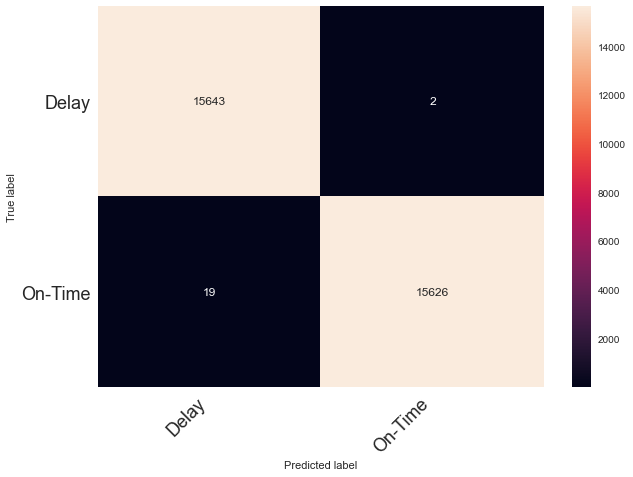

In [35]:
clf_ros = RandomForestClassifier().fit(X_ROS_val, y_ROS_val)
cm = print_confusion_matrix(confusion_matrix(y_ROS_val, clf_ros.predict(X_ROS_val)), ['Delay', 'On-Time'])

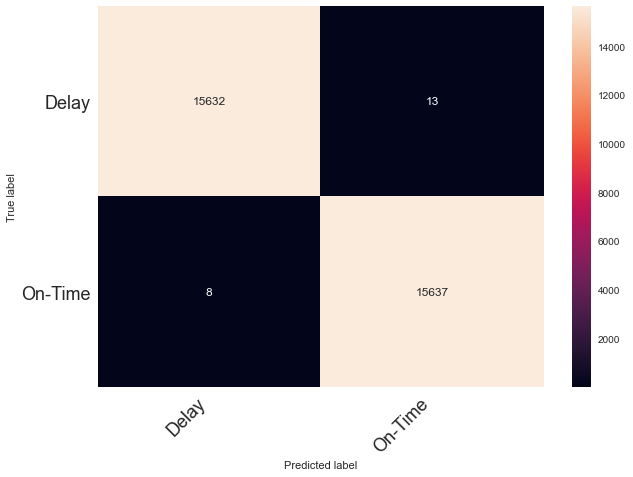

In [39]:
clf_smote = RandomForestClassifier().fit(X_SMOTE_val, y_SMOTE_val)
cm = print_confusion_matrix(confusion_matrix(y_ROS_val, clf_smote.predict(X_SMOTE_val)), ['Delay', 'On-Time'])

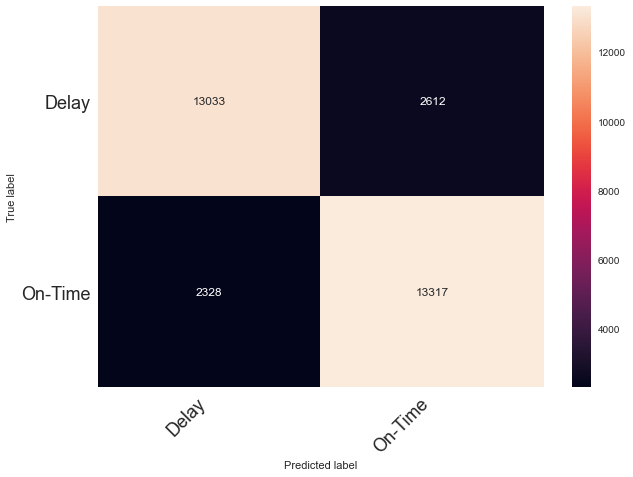

In [40]:
clf_ros = XGBClassifier().fit(X_ROS_val, y_ROS_val)
cm = print_confusion_matrix(confusion_matrix(y_ROS_val, clf_ros.predict(X_ROS_val)), ['Delay', 'On-Time'])

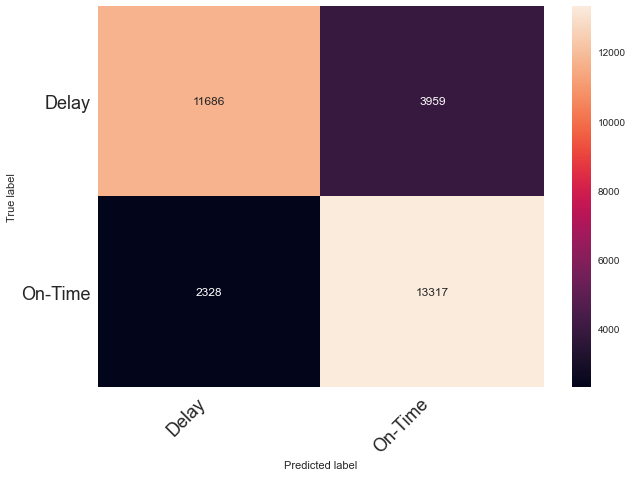

In [41]:
clf_smote = XGBClassifier().fit(X_SMOTE_val, y_SMOTE_val)
cm = print_confusion_matrix(confusion_matrix(y_SMOTE_val, clf_ros.predict(X_SMOTE_val)), ['Delay', 'On-Time'])

Ah-ha! We have found the culprit! The reason why our Random Forest Classifiers were giving a higher score was because of the nearly perfect balanced On-Time and Delay True Positives. Lets keep an eye on this and continue to move forward with cross-validation.

## 6.0 Cross-Validation

Steps for cross-validation:

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Benefits of cross-validation:

- More **reliable** estimate of out-of-sample performance than train/test split
- Can be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**

Drawbacks of cross-validation:

- Can be computationally **expensive**

### 6.1 Cross Validation without Balancing

In [20]:
names, accs = [], []

for model_names, model in models.items():
    accuracy = np.mean(cross_val_score(model, X_train_preprocessed, y_train, cv=10)) #10-fold cross validation
    print('%-30s %.4f' % (model_names, accuracy))
    names.append(model_names)
    accs.append(accuracy)

KNN                            0.7649
Logistic Regression            0.7524
Gaussian Naive Bayes           0.4687
Decision Tree Classifier       0.8949
Random Forest Classifier       0.8798
Gradient Boosted Classifer     0.8325


### 6.2 Cross Validation with Random Over Sampler

In [21]:
names, accs = [], []

for model_names, model in models.items():
    accuracy = np.mean(cross_val_score(model, X_ROS_train, y_ROS_train, cv=10)) #10-fold cross validation
    print('%-30s %.4f' % (model_names, accuracy))
    names.append(model_names)
    accs.append(accuracy)

KNN                            0.8184
Logistic Regression            0.6691
Gaussian Naive Bayes           0.5608
Decision Tree Classifier       0.9588
Random Forest Classifier       0.9582
Gradient Boosted Classifer     0.8038


### 6.3 Cross Validation with SMOTE

In [22]:
names, accs = [], []

for model_names, model in models.items():
    accuracy = np.mean(cross_val_score(model, X_SMOTE_train, y_SMOTE_train, cv=10)) #10-fold cross validation
    print('%-30s %.4f' % (model_names, accuracy))
    names.append(model_names)
    accs.append(accuracy)

KNN                            0.7969
Logistic Regression            0.6707
Gaussian Naive Bayes           0.5506
Decision Tree Classifier       0.8848
Random Forest Classifier       0.9028
Gradient Boosted Classifer     0.8344


The scores for Random Forest are either at 90 or close to it and due to the near perfect balance, which will require further investigation, we will continue to focus on Gradient Boosted Classifier with SMOTE.

## 7.0 Hyperparameter Tuning

Now let's finetune some of our parameters for XGBoost

**n_estimators**: number of base learner trees  
**max_depth**: max depth per base tree (typical values are 3-12)   
**learning_rate**: shrinkage factor applied to each base tree update  
**subsample**: row subsampling rate (similar to RF)   
**min_child_weight**: roughly the minimum allowable child samples for a tree split to occur  
**colsample_bytree**: feature subsampling rate (similar to RF) 

The use of a learning rate/shrinkage factor is a form of regularization that can greatly reduce overfitting. It typically trades off with the n_estimators and depth parameters (raising these add complexity) -- lower learning rate  usually wants higher n_estimators, higher max depth usually wants lower learning rate etc. The two subsampling parameters and min_child_weight are also forms of regularization. These types of tradeoffs are part of why it typically works better to follow a manual tuning procedure than to try a massive grid search across different parameter combinations. That simply doesn't scale well to large datasets. 

Instead of trying to pick n_estimators by hand or do an intensive grid search, we'll use the **early stopping** technique as a massive time saver. This means that we track our validation error at each update step in the training process, and halt training once validation error hasn't improved in some number of **early_stopping_rounds**. This way, we can set n_estimators to a very large number and simply train until we land at a good stopping point for validation error. 

(One technical problem with early stopping is that n_estimators selection can overfit to the validation data. One reasonable solution is to combine early stopping with k-fold cross validation, and use the average n_estimators across k training rounds for training a new model).   

In [43]:
gbm = XGBClassifier( 
                        n_estimators=3000,
                        max_depth=7,
                        objective='binary:logistic', #new objective
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_SMOTE_train,y_SMOTE_train),(X_SMOTE_val,y_SMOTE_val)]
fit_model = gbm.fit( 
                    X_SMOTE_train, y_SMOTE_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

In [51]:
y_pred = gbm.predict(X_SMOTE_val, ntree_limit=gbm.best_ntree_limit)

print('Gradient Boosted Classifier')
print("Validation accuracy score:{:6.2f}%\n".format(100*gbm.score(X_SMOTE_val, y_SMOTE_val)))
print("Classification Report")
print(classification_report(y_SMOTE_val, y_pred))

Gradient Boosted Classifier
Validation accuracy score: 89.65%

Classification Report
              precision    recall  f1-score   support

       DELAY       0.93      0.86      0.89     15645
      ONTIME       0.87      0.93      0.90     15645

    accuracy                           0.90     31290
   macro avg       0.90      0.90      0.90     31290
weighted avg       0.90      0.90      0.90     31290



This is amazing! Our scores have definitely gone up with the tuning! This is as high as the Random Classifier + SMOTE scores but with better balancing!

## 8.0 ROC and AUC curves

We've already seen that we don't have to accept a 50% threshold cutoff. As we've seen, we can plot our models with different thresholds on the same chart and get a ROC curve. This curve plots the *true positive rate* on the y axis, and the *false positive rate* on the x axis. 

The intepretation of the _Area Under the Curve_ (AUC) is the probability that a randomly chosen positive example (in this case, fraud) has a higher score than the randomly chosen negative example (in this case, legitimate transactions).

We will go ahead and plot all the models plus RandomOversampler and SMOTE to be as thorough as possible during our process. 

### 8.1 ROC and AUC Curve No Balancing

KNN
ROC AUC score =  0.7631391220143824
Logistic Regression
ROC AUC score =  0.7157963240698719
Gaussian Naive Bayes
ROC AUC score =  0.5752008519307756
Decision Tree Classifier
ROC AUC score =  0.850131114653216
Random Forest Classifier
ROC AUC score =  0.9404752999407014
Gradient Boosted Classifer
ROC AUC score =  0.8695344747994598


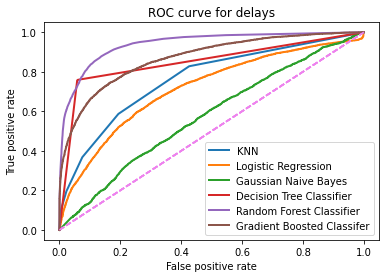

In [39]:
for model_name, model in models.items():
    # Precision = TP / (TP + FP)
    # Recall = TP/P = True positive rate
    # false positive rate = FP / true negatives = FP / (FP + TN) 
    model.fit(X_train_preprocessed,y_train)
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val_preprocessed)[:,1])

    plt.plot(fpr, tpr,lw=2, label=model_name)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.legend()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for delays');

    print(model_name)
    print("ROC AUC score = ", roc_auc_score(y_val, model.predict_proba(X_val_preprocessed)[:,1]))

### 8.2 ROC and AUC Curve + RandomOverSampling

KNN
ROC AUC score =  0.7960784590099871
Logistic Regression
ROC AUC score =  0.7135812660274236
Gaussian Naive Bayes
ROC AUC score =  0.5763213419836352
Decision Tree Classifier
ROC AUC score =  0.8560361982427912
Random Forest Classifier
ROC AUC score =  0.9395274405424527
Gradient Boosted Classifer
ROC AUC score =  0.8699972616706098


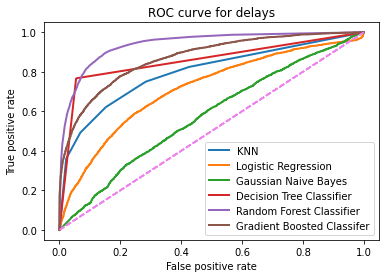

In [40]:
for model_name, model in models.items():
    # Precision = TP / (TP + FP)
    # Recall = TP/P = True positive rate
    # false positive rate = FP / true negatives = FP / (FP + TN) 
    model.fit(X_ROS_train,y_ROS_train)
    fpr, tpr, thresholds = roc_curve(y_ROS_val, model.predict_proba(X_ROS_val)[:,1])

    plt.plot(fpr, tpr,lw=2, label=model_name)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.legend()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for delays');

    print(model_name)
    print("ROC AUC score = ", roc_auc_score(y_ROS_val, model.predict_proba(X_ROS_val)[:,1]))

### 8.3 ROC and AUC Curve + SMOTE

KNN
ROC AUC score =  0.7979067642251412
Logistic Regression
ROC AUC score =  0.7231846719739801
Gaussian Naive Bayes
ROC AUC score =  0.5792590331930259
Decision Tree Classifier
ROC AUC score =  0.8670785069128772
Random Forest Classifier
ROC AUC score =  0.9500427826942076
Gradient Boosted Classifer
ROC AUC score =  0.9275431731180829


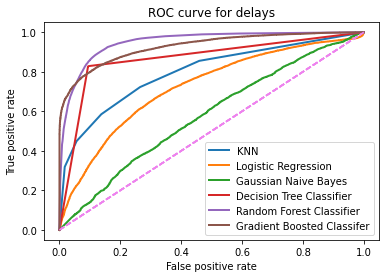

In [41]:
for model_name, model in models.items():
    # Precision = TP / (TP + FP)
    # Recall = TP/P = True positive rate
    # false positive rate = FP / true negatives = FP / (FP + TN) 
    model.fit(X_SMOTE_train,y_SMOTE_train)
    fpr, tpr, thresholds = roc_curve(y_SMOTE_val, model.predict_proba(X_SMOTE_val)[:,1])

    plt.plot(fpr, tpr,lw=2, label=model_name)
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.legend()
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for delays');

    print(model_name)
    print("ROC AUC score = ", roc_auc_score(y_SMOTE_val, model.predict_proba(X_SMOTE_val)[:,1]))

We see here all the possible TPRs and FNRs that we could have. It is a nice metric because looking at the behavior of our model, we can choose later what we want the threshold to be.

Now I can say with more certainty, with a score in the lower 90s, Gradient Boosted Classifier + SMOTE will be the final model for this project. Overall, I chose this combination over Random Forest and SMOTE because of the nearly perfect class balance after running SMOTE for Random Forest. That is something that needs to be explored further but I am confident in my decision with Gradient Boosted Classifier and SMOTE.

## 9.0 Final Model
For the final model, I have chosen Gradient Boosted Classifier with SMOTE to handle class imabalance. As aforementioned, it was the most realistically balanaced with high precision, recall, accuracy, f1, and ROC-AUC scors. I will run Feature Importance, Confusion Matrix, Classification Report, and finally the ROC-AUC curve on the test data to finish the model.

### 9.1 Feature Importance

In [ ]:
final_model = GradientBoostedClassifier()
figure(num=None, figsize=(15, 10), facecolor='w')

my_title = "Feature Importances in Determining Flight Delays"
visualizer = FeatureImportances(final_model, title=my_title, colors=["#6ca0dc", "#c76346"], relative=False)
visualizer.fit(X_test, y_test)

visualizer.show()
for label in visualizer.ax.texts:
    label.set_size(20);

### 9.2 Confusion Matrix

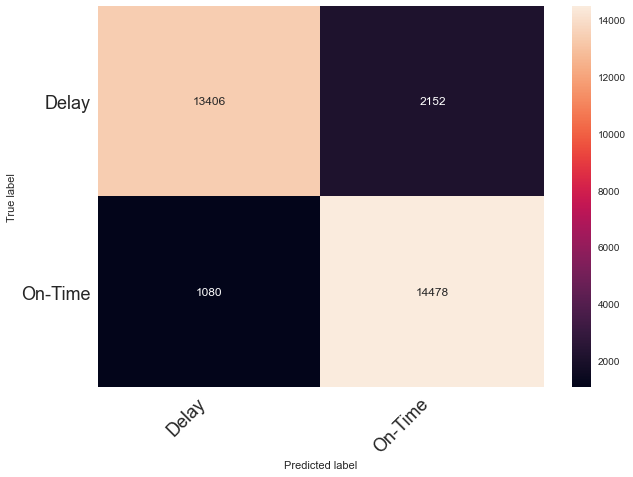

In [55]:
X_SMOTE_test, y_SMOTE_test = SMOTE().fit_sample(X_test_preprocessed, y_test)
cm = print_confusion_matrix(confusion_matrix(y_SMOTE_test, gbm.predict(X_SMOTE_test)), ['Delay', 'On-Time'])

### 9.3 Classification Report

In [ ]:
# final_model = final_model.fit(X_ROS_train,y_ROS_train)
# y_pred = final_model.predict(X_ROS_test)

# print("RandomForestClassifier with Random Oversampler")
# print("Validation accuracy score:{:6.2f}%\n".format(100*final_model.score(X_ROS_test, y_ROS_test)))
# print("Classification Report")
# print(classification_report(y_ROS_test, y_pred))

final_model = gbm.fit(X_SMOTE_train, y_SMOTE_train)
y_pred = gbm.predict(X_SMOTE_test, ntree_limit=gbm.best_ntree_limit),y_SMOTE_test)

print('Gradient Boosted Classifier')
print("Validation accuracy score:{:6.2f}%\n".format(100*final_model.score(X_SMOTE_test, y_SMOTE_test)))
print("Classification Report")
print(classification_report(y_SMOTE_test, y_pred))

### 9.4 ROC-AUC Curve

In [ ]:
fpr, tpr, thresholds = roc_curve(y_SMOTE_test, final_model.predict_proba(X_SMOTE_test)[:,1])

plt.plot(fpr, tpr,lw=2, label='Random Forest Classifier')
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.legend()
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for delays');

print('Gradient Boosted Classifier')
print("ROC AUC score = ", roc_auc_score(y_SMOTE_test, final_model.predict_proba(X_SMOTE_test)[:,1]))

## 10.0 Flask App Prep
This is in preparation for a potential future flask app. 

In [28]:
X_ROS, y_ROS = ros.fit_sample(X_preprocessed,y)
#final_model.fit(X_oversampled, np.array(y_oversampled).ravel())
final_model = final_model.fit(X_ROS,y_ROS)

In [29]:
final_model.feature_names = X.columns
final_model.feature_names

Index(['DAY_OF_WEEK', 'OP_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME', 'DISTANCE'], dtype='object')

In [30]:
final_model.target_names = y.unique()
final_model.target_names

array([0, 1])

In [31]:
test_input = np.random.rand(1, 131)
final_model.predict(test_input)

array([1])

In [33]:
f = open("final_model", "wb")
pickle.dump(final_model, f)
f.close()